In [2]:
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop, Adagrad
from keras.layers import BatchNormalization

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
positive_dir = '/kaggle/input/surface-crack-detection/Positive/'
negative_dir = '/kaggle/input/surface-crack-detection/Negative/'

positive_images = os.listdir(positive_dir)
negative_images = os.listdir(negative_dir)

len(positive_images), len(negative_images)


(20000, 20000)

In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Set the directories
positive_dir = '/kaggle/input/surface-crack-detection/Positive/'
negative_dir = '/kaggle/input/surface-crack-detection/Negative/'

# Assuming images are in PNG format and the target size is (224, 224)
image_size = (227, 227)
batch_size = 32

# Set up data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/surface-crack-detection/',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/kaggle/input/surface-crack-detection/',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)






Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [10]:
# Build a simple convolutional neural network (CNN) model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Set up early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_loss', save_best_only=True)

# ...

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5, 
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save('/kaggle/working/final_model.h5')

Epoch 1/5
1000/1000 [==============================] - 170s 170ms/step - loss: 0.1142 - accuracy: 0.9582 - val_loss: 0.0325 - val_accuracy: 0.9868
Epoch 2/5
1000/1000 [==============================] - 99s 99ms/step - loss: 0.0560 - accuracy: 0.9838 - val_loss: 0.0491 - val_accuracy: 0.9825
Epoch 3/5
1000/1000 [==============================] - 107s 107ms/step - loss: 0.0486 - accuracy: 0.9855 - val_loss: 0.0181 - val_accuracy: 0.9949
Epoch 4/5
1000/1000 [==============================] - 104s 104ms/step - loss: 0.0333 - accuracy: 0.9902 - val_loss: 0.0171 - val_accuracy: 0.9948
Epoch 5/5
1000/1000 [==============================] - 109s 109ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.0254 - val_accuracy: 0.9918


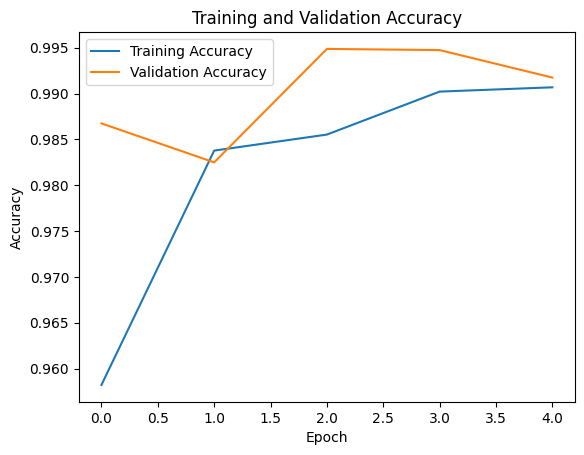

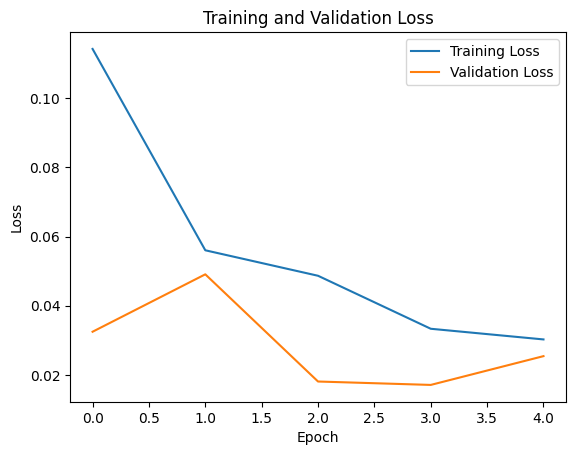

In [14]:


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('/kaggle/working/best_model.h5')  

# Open the video file
video_path = '/kaggle/input/hfghgfhgfh/VID20240119142855.mp4'
cap = cv2.VideoCapture(video_path)

output_path = '/kaggle/working/output_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()
    
    if not ret:
        break  
    
    resized_frame = cv2.resize(frame, (227, 227))
    img_array = image.img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make a prediction
    prediction = model.predict(img_array)
    
    if prediction[0][0] > 0.5:
        h, w, _ = frame.shape
        x = int(w * 0.05)  
        y = int(h * 0.05)  
        w = int(w * 0.9)  
        h = int(h * 0.9)   #

        # Draw the bounding box
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        label = "Crack Detected"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        # Position the label above the bounding box
        text_position = ((w - text_size[0]) // 2 + x, y - 10)
        cv2.putText(frame, label, text_position, font, font_scale, (255, 0, 0), font_thickness, cv2.LINE_AA)
    
    # Write the frame to the output video
    output_video.write(frame)

# Release the video capture and writer objects
cap.release()
output_video.release()


1/1 [==============================] - 0s 19ms/step
